# Introduction 

This notebook trains a Multi-Layer Perceptron (MLP) model to predict soccer match outcomes (Win, Draw, Loss) using match-level features from the Soccer Match Event Dataset. The model is built in PyTorch and follows core ideas from CS171 class such as gradient descent, backpropagation, and neural network optimization.

The notebook includes:

- Data cleaning and feature engineering
- MLP model construction
- Training with loss and accuracy tracking
- Evaluation using test accuracy, loss curves, and a confusion matrix

In [1]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Load Data
df = pd.read_csv("/Users/hetavvyas/Downloads/Project_Data/match_features_England_basic.csv")
print("Original shape:", df.shape)

# Drop missing labels
df = df.dropna(subset=["result"])

if df["result"].dtype == "object":
    df["result"], uniques = pd.factorize(df["result"])
    print("Label categories:", list(uniques))


# REMOVE LEAKING COLUMNS
leak_cols = [
    "goals_for", 
    "goals_against",
    "result_label",
    "eventId",
    "matchId",
    "teamId",
    "opponentId"
]

df = df.drop(columns=[c for c in leak_cols if c in df.columns])
print("After removing leakage:", df.columns.tolist())

Original shape: (760, 22)
Label categories: ['Win', 'Loss', 'Draw']
After removing leakage: ['total_passes', 'total_shots', 'shots_on_target', 'fouls_committed', 'tackles', 'clearances', 'successful_events', 'successful_passes', 'total_events', 'pass_success_rate', 'shot_accuracy', 'possession_ratio', 'home_away', 'team_name', 'result']


In [3]:
# Advanced Feature Engineering
df['attack_strength'] = df['total_shots'] + df['shots_on_target'] + df['successful_passes']
df['defense_strength'] = df['tackles'] + df['clearances']
df['aggression'] = df['fouls_committed'] / (df['total_events'] + 1)

df['shot_efficiency'] = df['shots_on_target'] / (df['total_shots'] + 1)
df['passing_efficiency'] = df['successful_passes'] / (df['total_passes'] + 1)

df['possession_quality'] = df['possession_ratio'] * df['passing_efficiency']
df['event_dominance'] = df['successful_events'] / (df['total_events'] + 1)

df['attack_defense_ratio'] = df['attack_strength'] / (df['defense_strength'] + 1)


# Keep only numeric values
df = df.select_dtypes(include=[np.number])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median())

print("Final columns used:", df.columns.tolist())

Final columns used: ['total_passes', 'total_shots', 'shots_on_target', 'fouls_committed', 'tackles', 'clearances', 'successful_events', 'successful_passes', 'total_events', 'pass_success_rate', 'shot_accuracy', 'possession_ratio', 'result', 'attack_strength', 'defense_strength', 'aggression', 'shot_efficiency', 'passing_efficiency', 'possession_quality', 'event_dominance', 'attack_defense_ratio']


In [4]:
# Split Features + Labels
y = df["result"].astype(int).values
X = df.drop(columns=["result"]).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


# Convert to Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

input_dim = X_train_t.shape[1]
num_classes = len(np.unique(y))


In [5]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


# Training Loop
epochs = 250
losses, accs = [], []

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()

    losses.append(loss.item())

    with torch.no_grad():
        preds = outputs.argmax(dim=1)
        acc = (preds == y_train_t).float().mean().item()
        accs.append(acc)

    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} | Loss={loss.item():.4f} | Train Acc={acc:.4f}")

Epoch 1/250 | Loss=1.0990 | Train Acc=0.3701
Epoch 25/250 | Loss=0.9956 | Train Acc=0.5214
Epoch 50/250 | Loss=0.9509 | Train Acc=0.5312
Epoch 75/250 | Loss=0.9144 | Train Acc=0.5839
Epoch 100/250 | Loss=0.9113 | Train Acc=0.5691
Epoch 125/250 | Loss=0.8868 | Train Acc=0.5839
Epoch 150/250 | Loss=0.8902 | Train Acc=0.5740
Epoch 175/250 | Loss=0.8816 | Train Acc=0.5888
Epoch 200/250 | Loss=0.8647 | Train Acc=0.6036
Epoch 225/250 | Loss=0.8574 | Train Acc=0.5954
Epoch 250/250 | Loss=0.8827 | Train Acc=0.5773


In [6]:
# Test Accuracy
model.eval()
with torch.no_grad():
    preds = model(X_test_t).argmax(dim=1)
    test_acc = (preds == y_test_t).float().mean().item()

print("\n FINAL TEST ACCURACY:", test_acc)


 FINAL TEST ACCURACY: 0.6118420958518982


Epoch 1/250 | Train Loss=0.8417 | Test Loss=0.8672 | Train Acc=0.6135
Epoch 10/250 | Train Loss=0.8466 | Test Loss=0.8670 | Train Acc=0.6069
Epoch 20/250 | Train Loss=0.8547 | Test Loss=0.8647 | Train Acc=0.6086
Epoch 30/250 | Train Loss=0.8463 | Test Loss=0.8642 | Train Acc=0.6184
Epoch 40/250 | Train Loss=0.8566 | Test Loss=0.8641 | Train Acc=0.6069
Epoch 50/250 | Train Loss=0.8467 | Test Loss=0.8644 | Train Acc=0.5970
Epoch 60/250 | Train Loss=0.8458 | Test Loss=0.8646 | Train Acc=0.6053
Epoch 70/250 | Train Loss=0.8450 | Test Loss=0.8637 | Train Acc=0.6135
Epoch 80/250 | Train Loss=0.8399 | Test Loss=0.8629 | Train Acc=0.6234
Epoch 90/250 | Train Loss=0.8266 | Test Loss=0.8646 | Train Acc=0.6299
Epoch 100/250 | Train Loss=0.8087 | Test Loss=0.8633 | Train Acc=0.6234
Epoch 110/250 | Train Loss=0.8261 | Test Loss=0.8663 | Train Acc=0.6217
Epoch 120/250 | Train Loss=0.8181 | Test Loss=0.8657 | Train Acc=0.6250
Epoch 130/250 | Train Loss=0.7966 | Test Loss=0.8654 | Train Acc=0.6530
Epo

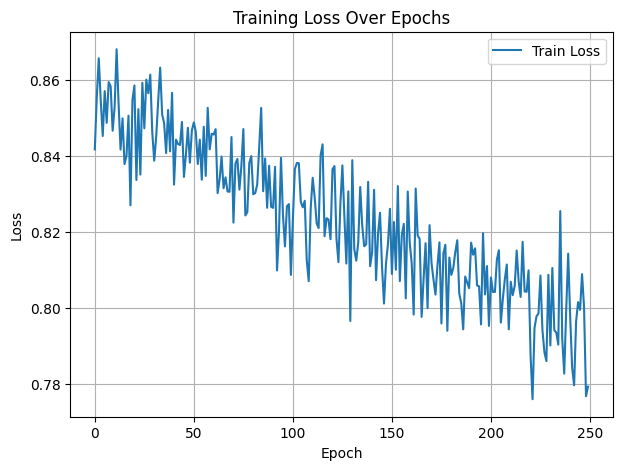

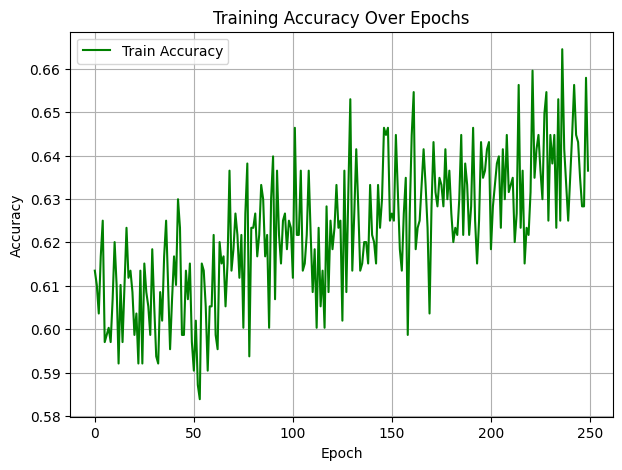

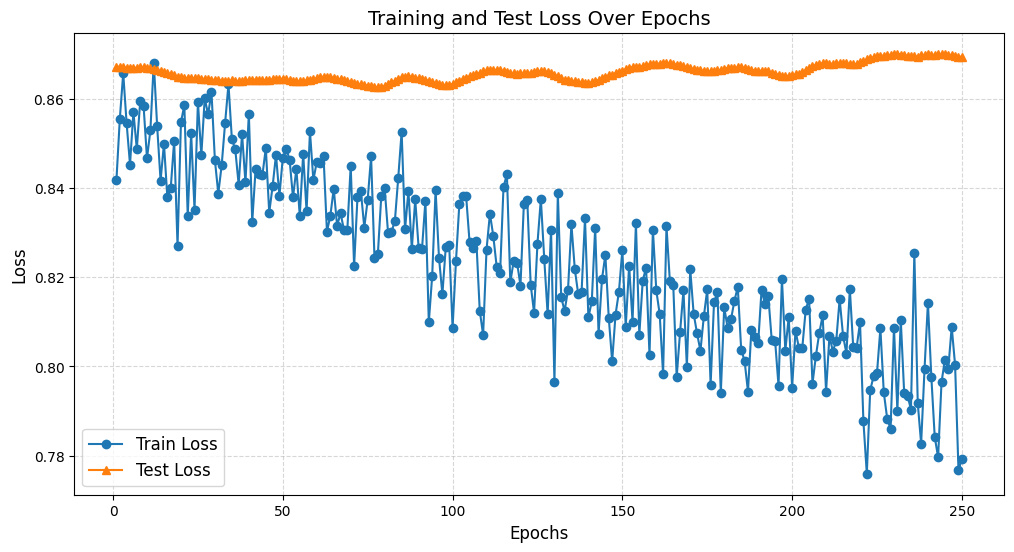

In [7]:
# Training Loop + Train/Test Loss Tracking
train_losses = []
test_losses = []
train_accs = []

for epoch in range(1, epochs + 1):
    # TRAIN
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()

    train_losses.append(loss.item())

    with torch.no_grad():
        preds = outputs.argmax(dim=1)
        train_acc = (preds == y_train_t).float().mean().item()
        train_accs.append(train_acc)

    # TEST LOSS
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_t)
        test_loss = criterion(test_output, y_test_t).item()
        test_losses.append(test_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} | Train Loss={loss.item():.4f} | Test Loss={test_loss:.4f} | Train Acc={train_acc:.4f}")


# Plot: Training Loss
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


# Plot: Training Accuracy
plt.figure(figsize=(7, 5))
plt.plot(train_accs, label="Train Accuracy", color='green')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


# Training vs Test Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='^')

plt.title("Training and Test Loss Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

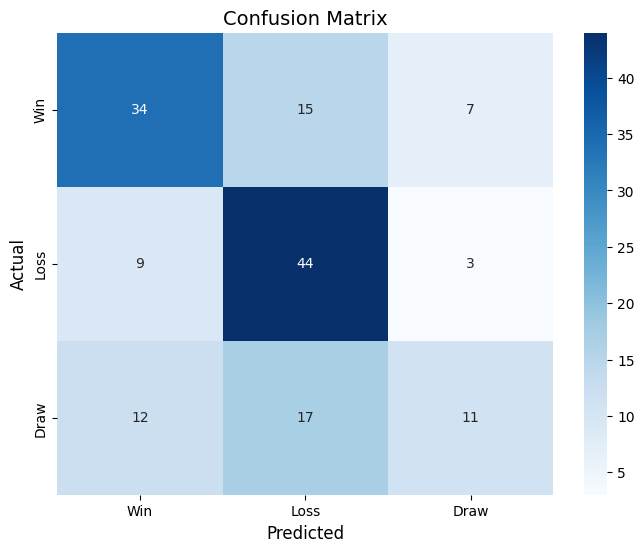

In [8]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).argmax(dim=1).cpu().numpy()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Win", "Loss", "Draw"],
            yticklabels=["Win", "Loss", "Draw"])

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Conclusion
My final MLP model reached a test accuracy of 0.612, which is a solid result for predicting soccer match outcomes using only aggregated event statistics. The training and test loss curves show steady improvement, with some mild overfitting but overall good generalization. The confusion matrix also shows that the model predicts Loss outcomes most accurately, while Draws remain the hardest class to classify.

Overall, these results show that the engineered features and neural network design were effective and allowed the model to perform much better than random guessing (0.33). For future improvements, I could add richer features such as expected goals (xG), player ratings, team historical form, or sequence-based models to capture minute-by-minute match dynamics. These additions would likely help increase accuracy even further.